# Load Data and Libraries

In [1]:
#import the necessary libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define file path
dataset_path = "Sneaker_Data.csv"

# View dataset as a dataframe
sneaker_df = pd.read_csv(dataset_path)
sneaker_df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11
...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:17
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16
4997,4998,56,867,351,3,cash,2017-03-19 5:42:42
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18


In [3]:
# Verify "naive AOV" calculation
order_amount = sneaker_df['order_amount']
aov = np.around(np.mean(order_amount), decimals=2)
print("Naive AOV = " +  "$" + str(aov))

Naive AOV = $3145.13


In [4]:
def num_bins(data):
    """
    Takes a column from a Dataframe and calculates the number of bins to use in its histogram.

    Number of bins calculated is based on the Freedman-Diaconis Rule.

    :param
    data (Dataframe): Column from a Dataframe whose values are to be displayed on the histogram

    :return
    int: Number of bins to use in histogram for the given data

    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3-q1
    n = data.size
    bin_width = 2*(iqr/np.cbrt(n))
    bins = (data.max() - data.min())/bin_width
    return int(bins)

# determine the range of values for 'order_amount'
max_order = order_amount.max()
min_order = order_amount.min()
print("The max order amount was $" + str(max_order)
      + ". The min order amount was $" + str(min_order))

The max order amount was $704000. The min order amount was $90


# Order Amount Visualization With Histogram
- Since there is a large range of order amounts, I will visualize the data using a natural log scale

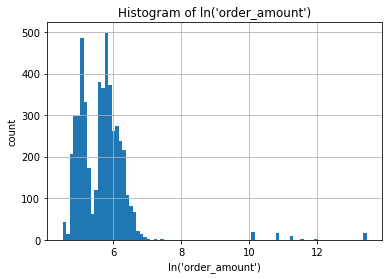

In [5]:
# Histogram of ln('order_amount')
sneaker_df['ln_order_amount'] = np.log(order_amount)
n_bins = num_bins(sneaker_df['ln_order_amount'])
sneaker_df.hist(column='ln_order_amount', bins=n_bins)

plt.xlabel("ln('order_amount')")
plt.ylabel('count')
plt.title("Histogram of ln('order_amount')")
plt.show()

# Histogram Interpretation
- From the histogram we see there are relatively few orders with very large order amounts
- This suggests that our data may contain outliers that should be removed

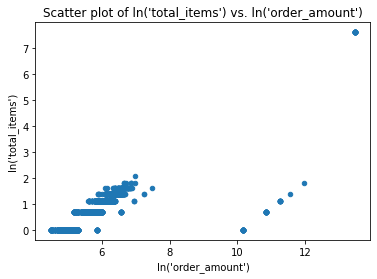

In [6]:
# More visualization of the orders
sneaker_df['ln_total_items'] = np.log(sneaker_df['total_items'])
sneaker_df.plot.scatter(x='ln_order_amount', y='ln_total_items')

plt.xlabel("ln('order_amount')")
plt.ylabel("ln('total_items')")
plt.title("Scatter plot of ln('total_items') vs. ln('order_amount')")
plt.show()

# Scatter Plot Interpretation
- Some of the orders are very expensive yet have few items (bottom right). We will attempt to remove these using
outlier discrimination.
- The scatter plot was done using a natural logarithm scale for both axes. The reason for this is that there are large
 ranges for each of the values.

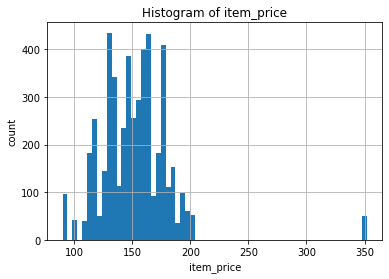

In [7]:
# Remove outliers where item price is unusually high
sneaker_df['item_price'] = sneaker_df['order_amount']/sneaker_df['total_items']
item_price = sneaker_df['item_price']
sneaker_df = sneaker_df.loc[np.abs(item_price - np.mean(item_price)) <= (3*np.std(item_price))]

# Visual distribution of item price
n_bins_2 = num_bins(sneaker_df['item_price'])
sneaker_df.hist(column='item_price', bins=n_bins_2)
plt.xlabel("item_price")
plt.ylabel('count')
plt.title("Histogram of item_price")
plt.show()

# Histogram Interpretation
- Assuming that the price of the sneakers sold was approximately normally distributed,
we can remove orders where the sneaker price was 3 or more standard deviations from the mean.

- After removing outliers, we see there are relatively few sales of sneakers at about $350 per pair.

In [8]:
# look at orders with higher priced sneakers
mean_price = np.mean(sneaker_df['item_price'])
std_price = np.std(sneaker_df['item_price'])

high_price = sneaker_df.loc[(item_price - mean_price) > (2*std_price)]
high_price.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,ln_order_amount,ln_total_items,item_price
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,13.464534,7.600902,352.0
40,41,42,793,352,1,credit_card,2017-03-24 14:15:41,5.863631,0.000000,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,13.464534,7.600902,352.0
308,309,42,770,352,1,credit_card,2017-03-11 18:14:39,5.863631,0.000000,352.0
409,410,42,904,704,2,credit_card,2017-03-04 14:32:58,6.556778,0.693147,352.0


# Suspiciously Large Orders

- From the dataframe above we see that shop 42 has multiple large order amounts of $704000.
- To determine if these orders are possible instances of fraud we will use some of the indicators of fraud from the Government of Canada's website (https://www.fintrac-canafe.gc.ca/guidance-directives/transaction-operation/indicators-indicateurs/fin_mltf-eng#s6)
- First we will see if any transactions by any user in the database are duplicated

In [9]:
# Check if there are any double charges
double_charges = sneaker_df.groupby(['user_id', 'created_at']).size().reset_index(name='counts')
double_charges = double_charges.loc[double_charges['counts'] >=2]
double_charges

,user_id,created_at,counts
0,607,2017-03-02 4:00:00,2
2,607,2017-03-07 4:00:00,2
9,607,2017-03-24 4:00:00,2
11,607,2017-03-28 4:00:00,3


# Possible Instance of Fraud

- Since user 607 has suspicious transactions patterns (e.g same time of day, multiple
transactions at the same time), I will remove their transactions since they are likely fraudulent

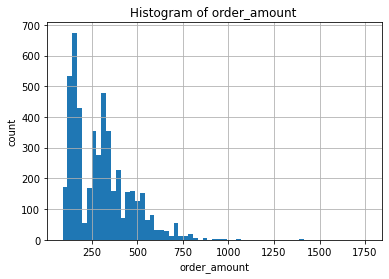

In [10]:
# Remove user 607
sneaker_df = sneaker_df.loc[sneaker_df['user_id'] != 607]

# Re-examine the order_amount data after cleaning the dataset
n_bins_3 = num_bins(sneaker_df['order_amount'])
sneaker_df.hist(column='order_amount', bins=n_bins_3)

plt.xlabel('order_amount')
plt.ylabel('count')
plt.title('Histogram of order_amount ')
plt.show()

# Final Sales Metric
- Since the data is left-skewed I will use median as the measure of central tendency
rather than the mean. I will then calculate the median order value.

In [11]:
# Calculating the Median Order Value (MOV)
MOV = np.median(sneaker_df['order_amount'])
print("The median order value is $" + str(MOV))


The median order value is $284.0
